In [1]:
import numpy as np
import pfnet as pf
from scipy.sparse import triu,bmat,coo_matrix,eye,spdiags
import matplotlib.pyplot as plt
from scikits.sparse.cholmod import cholesky
import time

%matplotlib inline  

In [2]:
net=pf.Network()
# net.load('PFNET-multi_period/data/ieee14.mat')
net.load('PFNET-multi_period/data/ieee300.mat')


In [3]:
penetration=50.
net.add_vargens(net.get_gen_buses(),#[net.get_bus(1)], 
                penetration, 50., 10, 0.1)


In [4]:
# Problem set up

total_load = sum([l.P for l in net.loads])
total_capacity=sum([gen.P_max for gen in net.generators])
uncertainty = 100.*sum([g.P_std for g in net.var_generators])/sum([g.P_max for g in net.var_generators])
corr_value = net.vargen_corr_value 
corr_radius = net.vargen_corr_radius

for br in net.branches:
    if br.ratingA==0:
        br.ratingA = 15

for gen in net.generators:
    gen.P_min = 0.
    gen.P_max = np.maximum(gen.P_max,0.)
    assert(gen.P_min <= gen.P_max)


num_w = net.num_buses-net.get_num_slack_buses() # voltage angles
num_p = net.get_num_P_adjust_gens()             #net.get_num_generators()         # adjustable generators
num_r = net.num_var_generators                       # renewable generators
num_bus = net.num_buses                         # buses
num_br = net.num_branches                       # branches
num_l = net.num_loads

In [5]:
# [gen.P_max for gen in net.generators]

In [6]:
# capacity_per=np.ones(5)/5
# capacity_per=np.array([0.23494860499265785, 0.00279001468428781, 0.48208516886930984, 0.13906020558002939, 0.141116005873715125])
capacity_per=np.array([0.23494860499265785, 0.30279001468428781, 0.18208516886930984, 0.23906020558002939, 0.041116005873715125])

#([0.25, 0.50, 0.15, 0.05, 0.05 ])#
capacity_per_cumsum=np.cumsum(capacity_per)
sorted_gen=np.array(sorted([gen.P_max  for gen in net.generators]))
gen_cumsum=np.cumsum(sorted_gen)
gen_bounds=np.zeros(len(capacity_per)+1)
gen_bounds[0]=100
for idx,cap in enumerate(capacity_per_cumsum):
    gen_bounds[idx+1]=np.min(sorted_gen[gen_cumsum/total_capacity>=(1-cap)])
gen_bounds[-1]=0
parameters=[('Nuclear', 0.029917833750000022, 3.0741044999999803, 100, 400.0, 280.0, 280.0, 24.0, 168.0, 40000.0),
('Coal', 0.11954207142857155, 12.270104999999957, 140, 350.0, 140.0, 140.0, 5.0, 8.0, 12064.0),
('IGCC', 0.25331129032258076, 10.655729999999988, 54, 155.0, 70.0, 80.0, 16.0, 24.0, 2058.0),
('CCGT', 0.14437728426395943, 7.7242649999999946, 104, 197.0, 310.0, 310.0, 3.0, 4.0, 230.0),
('OCGT', 2.2680749999999974, 13.795700000000027, 8, 20.0, 90.0, 100.0, 1.0, 2.0, 46.0)]


In [7]:
# for i in range(0,len(gen_bounds)-1):
#     print np.sum([gen.P_max/total_capacity for gen in net.generators if gen.P_max>gen_bounds[i+1] and gen.P_max < gen_bounds[i] ])

In [8]:
# np.sum([gen.P_max for gen in net.generators if gen.P_max<=gen_bounds[0] and gen.P_max>gen_bounds[1] ])/total_load

In [9]:
min_down=np.zeros([num_p])
min_up=np.zeros([num_p])
ramp_up=np.zeros([num_p])
ramp_down=np.zeros([num_p])
on_off_cost=np.zeros([num_p])
beta=1.0

gen_tech=np.chararray([num_p],itemsize=10)
for i in reversed(range(0,len(gen_bounds)-1)): 
    for gen in net.generators:
        if gen.P_max >= gen_bounds[i+1] and gen.P_max < gen_bounds[i]:
            aggregator= (np.maximum(gen.P_max/(parameters[i][4]/net.base_power),0))
#             print aggregator,parameters[i][0],gen.index
            gen.P_max= aggregator*parameters[i][4]/net.base_power
            gen.P_min= aggregator*parameters[i][3]/net.base_power
            gen.cost_coeff_Q2= net.base_power**2*parameters[i][1]/aggregator
            gen.cost_coeff_Q1= net.base_power*parameters[i][2]/aggregator
            gen.dP_max= parameters[i][5]/net.base_power*aggregator
            
            ramp_up[gen.index]=(aggregator*parameters[i][5])/net.base_power*beta
            ramp_down[gen.index]=(aggregator*parameters[i][6])/net.base_power*beta
            min_down[gen.index]= parameters[i][7]
            min_up[gen.index] = parameters[i][8]
            on_off_cost[gen.index] =parameters[i][9]*aggregator
            
            gen_tech[gen.index] = parameters[i][0]
            
name_techno=list(set([techno[0] for techno in parameters]))


In [10]:
for name in name_techno:
    print (name,np.sum([ gen.P_max for idx,gen in enumerate( net.generators) if gen_tech[idx]==name ])/total_capacity)

('Nuclear', 0.24156618883370642)
('IGCC', 0.1789559383734258)
('CCGT', 0.23091681104067566)
('OCGT', 0.040026396612934501)
('Coal', 0.30853466513925776)


In [11]:
print sum([gen.P_max for gen in net.generators]), total_capacity

326.78435 326.78435


In [12]:
for idx, name in enumerate(name_techno):
    print sum([1 for i in range(num_p) if gen_tech[i]==name]),name

4 Nuclear
12 IGCC
28 CCGT
13 OCGT
12 Coal


In [13]:
# sorted([(gen.index , gen.P_max) for idx , gen in enumerate( net.generators)],
#        key = lambda x: float(x[1]),reverse=True)
    

In [14]:
net.clear_flags()
net.set_flags(pf.OBJ_BUS,
              pf.FLAG_VARS,
              pf.BUS_PROP_NOT_SLACK,
              pf.BUS_VAR_VANG)
net.set_flags(pf.OBJ_GEN,
              pf.FLAG_VARS,
              pf.GEN_PROP_P_ADJUST,
              pf.GEN_VAR_P)
net.set_flags(pf.OBJ_VARGEN,
              pf.FLAG_VARS,
              pf.VARGEN_PROP_ANY,
              pf.VARGEN_VAR_P)
net.set_flags(pf.OBJ_LOAD,
              pf.FLAG_VARS,
              pf.LOAD_PROP_ANY,
              pf.LOAD_VAR_P)



In [15]:
x = net.get_var_values()
Pw = net.get_var_projection(pf.OBJ_BUS,pf.BUS_VAR_VANG)
Pp = net.get_var_projection(pf.OBJ_GEN,pf.GEN_VAR_P)
Pr = net.get_var_projection(pf.OBJ_VARGEN,pf.VARGEN_VAR_P)
Pd = net.get_var_projection(pf.OBJ_LOAD,pf.LOAD_VAR_P)


In [16]:
pf_eq = pf.Constraint(pf.CONSTR_TYPE_DCPF,net)
pf_eq.analyze()
pf_eq.eval(x)
AA = pf_eq.A.copy()
bb = pf_eq.b.copy()

In [17]:
fl_lim = pf.Constraint(pf.CONSTR_TYPE_DC_FLOW_LIM,net)
fl_lim.analyze()
fl_lim.eval(x)
GG = fl_lim.G.copy()
hl = fl_lim.l.copy()
hu = fl_lim.u.copy()

In [18]:
cost = pf.Function(pf.FUNC_TYPE_GEN_COST,1.,net)
cost.analyze()
cost.eval(x)
H = (cost.Hphi + cost.Hphi.T - triu(cost.Hphi)) # symmetric
g = cost.gphi - H*x
l = net.get_var_values(pf.LOWER_LIMITS)
u = net.get_var_values(pf.UPPER_LIMITS)

In [19]:
p_max = Pp*u
p_min = Pp*l
w_max = 5*np.ones(num_w)
w_min = -5*np.ones(num_w)
r_max = Pr*u
r_base = Pr*x
z_max = hu
z_min = hl 
H0 = Pp*H*Pp.T # change costs
g0 = Pp*g
#H1 = self.H0*self.parameters['cost_factor']
g1 = np.zeros(num_p)
G = AA*Pp.T
R = AA*Pr.T
A = -AA*Pw.T
Dm = -AA*Pd.T
J = GG*Pw.T 
b = bb
ll= Pd*x #np.array([l.P for l in net.loads]) # check 



In [20]:
rr_cov = Pr*net.create_vargen_P_sigma(corr_radius,corr_value)*Pr.T
r_cov = (rr_cov+rr_cov.T-triu(rr_cov)).tocsc()
factor = cholesky(r_cov)
LL,D = factor.L_D()
P = factor.P()
PT = coo_matrix((np.ones(P.size),(P,np.arange(P.size))),shape=D.shape)
D = D.tocoo()
Dh = coo_matrix((np.sqrt(D.data),(D.row,D.col)),shape=D.shape)
L = PT*LL*Dh

In [21]:
from cvxpy import *
import mosek
import gurobi

In [22]:
PWL=True

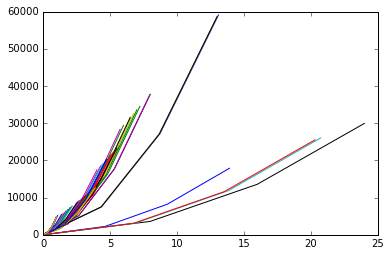

In [23]:
# PWL approximation
pwl_cost=[]
if PWL:
    pwl_points=3
    pwl_cost=np.zeros([num_p,pwl_points])
    for gen_id in range(num_p):
        xx=np.linspace(p_min[gen_id]*0,p_max[gen_id],pwl_points+1)
        y=np.zeros(pwl_points+1)
        for i in range(0,pwl_points+1):
            y[i]=0.5*H0.diagonal()[gen_id]*xx[i]**2+g0[gen_id]*xx[i]
            pwl_cost[gen_id][i-1]=((y[i]-y[i-1])/(xx[i]-xx[i-1]))
        plt.plot(xx,y)

    for gen_id in range(num_p):
        for i in range(1,pwl_points):
            assert pwl_cost[gen_id][i]>pwl_cost[gen_id][i-1]
            

plt.show()

In [24]:
norm_factor=24*num_p
H0=H0/(norm_factor)
g0=g0/(norm_factor)
pwl_cost=pwl_cost/norm_factor
on_off_cost=on_off_cost/norm_factor

In [25]:
load_data=np.genfromtxt('BPA_data/day6.csv',delimiter=',',names=True)
r_test=np.flipud(load_data['wind'])*total_load*(penetration/100)/num_r

In [26]:
np.random.seed(seed=100)
n_h=24
p=Variable(num_p,n_h)
w=Variable(num_w,n_h)
z=Variable(num_br,n_h)
s=Variable(num_r,n_h)
load=Variable(num_l,n_h)
on_off=Bool(num_p,n_h)
on_off_param=Parameter(num_p,n_h)
r_parameter=Parameter(num_r,n_h)
g_k2=Parameter(2*n_h,num_p)

Pforecast=total_load
Load_Penalty=np.max(pwl_cost)*1e1#1e6
# p_min = p_max*0.0
rampup = ramp_up #p_max/(H0.diagonal()/np.max(H0))*0.04 # p_max*0.01
rampdown=ramp_down #p_max/(H0.diagonal()/np.max(H0))*0.04 # p_max*0.01

if PWL:
    gk=Variable(num_p*pwl_points,n_h)


ontime=np.zeros(num_p)-25
on_off_init=np.zeros(num_p)

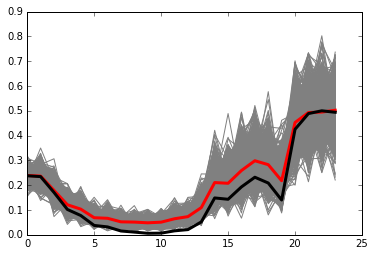

In [27]:
np.random.seed(seed=100)
mult=1.#2.5
n_samples=100
n_test=1000
scenarios=np.zeros([n_samples+n_test,n_h])
scenarios_bus=np.zeros([num_r,n_h,n_samples+n_test])
b=[]
b=np.zeros([num_l,n_h])
for i in range (n_h):
    b[:,i]=mult*np.abs(ll)*load_data['load'][i]#/load_data['load'][0]

for j in range(n_samples+n_test):
    r=[]
    r=np.zeros([num_r,n_h])
    for i in range (n_h):
        r[:,i]=mult*np.minimum(np.maximum(r_test[i]*np.ones(num_r)# +0.1 ieee14
                                     +L*np.random.randn(num_r)*np.sqrt(r_test[i]+0.1)*np.sqrt((i*1.+1)/(n_h)),1e-3),r_max)
    scenarios_bus[:,:,j]=r
    scenarios[j,:]=sum(r)
    plt.plot(sum(r)/total_load,color='gray')

plt.plot(np.mean(scenarios,0)/total_load,color='r',linewidth=3.0)
plt.plot(mult*r_test*num_r/total_load,color='k',linewidth=3.0)
plt.show()

In [28]:
# plt.plot(np.sum(np.mean(scenarios_bus,2),0))
# plt.plot(np.sum(r,0))
# plt.show()
r=np.mean(scenarios_bus,2)*0
rr=np.mean(scenarios_bus,2)

In [29]:
r=rr

In [30]:
def eval_on_off(on_off_value,r,prob,Constraints,duals=False,solver=GUROBI):
    dual_multiplier_pos=np.matrix(np.zeros((n_h,num_p)))
    dual_multiplier_neg=np.matrix(np.zeros((n_h,num_p)))
    
    on_off_param.value=on_off_value
    r_parameter.value=r
        
    if solver==GUROBI:
        Q=prob.solve(solver=GUROBI,BarQCPConvTol=1e-8,warm_start=True)#GUROBI,BarQCPConvTol=1e-8
        print "GUROBI"
    else:
        print "ECOS"
        Q=prob.solve(solver=ECOS,reltol=1e-8,max_iters=1000,warm_start=True)

    
    for i in range(n_h):
        dual_multiplier_pos[i,: ]= np.squeeze( np.asarray((np.diag(p_max)*Constraints[i].dual_value).T))
    for i in range(n_h):
        dual_multiplier_neg[i,: ]= np.squeeze( np.asarray((np.diag(p_min)*Constraints[i+n_h].dual_value).T))
        
    if not duals:
        return Q,p.value,load.value,s.value
    else:
        return Q, dual_multiplier_pos, dual_multiplier_neg
    


In [31]:
def second_stage(on_off_value,PWL):
    Constraints=[]
    for i in range (n_h):
        Constraints.append(p[:,i]<=mul_elemwise(p_max[:],on_off_value[:,i]))
    for i in range (n_h):
        Constraints.append(p[:,i]>=mul_elemwise(p_min[:],on_off_value[:,i]))
    for i in range (n_h):
        Constraints.append(s[:,i]<=r_parameter[:,i])

    for i in range (n_h):
        if PWL:
            for j in range (pwl_points):
                Constraints.append(gk[num_p*j:num_p*(j+1),i]<=p_max/(pwl_points))
                Constraints.append(gk[num_p*j:num_p*(j+1),i]>=0)

            Constraints.append( p[:,i]== np.sum ([gk[num_p*j:num_p*(j+1),i] for j in range(pwl_points)]) )

        Constraints.append(G*p[:,i]+R*s[:,i]-A*w[:,i]==Dm*load[:,i])
        Constraints.append(w[:,i]<=w_max)
        Constraints.append(w[:,i]>=w_min)
        Constraints.append(J*w[:,i]<=z_max)
        Constraints.append(J*w[:,i]>=z_min)
        #Changed here
        Constraints.append(s[:,i]>=0)
        Constraints.append(load[:,i]>=0)
        Constraints.append(load[:,i]<=b[:,i])
    for i in range(1,n_h):
        Constraints.append(p[:,i]-p[:,i-1]<=rampup[:])
        Constraints.append(p[:,i]-p[:,i-1]>=-rampdown[:])   


    # init objective secon stage

    Objective=0
    for i in range (n_h):
        if PWL:
            for j in range(pwl_points):
                for k in range(num_p):
                    Objective=Objective + gk[k+(num_p*j),i]*pwl_cost[k,j]
        else:
            Objective=Objective + quad_form(p[:,i],H0*0.5)
            Objective=Objective + g0*p[:,i]# check 

        Objective=Objective + Load_Penalty*norm(load[:,i]-b[:,i],1)
    
    return Objective , Constraints



In [32]:
Objective_det=0
Constraints_det=[]
Objective_det, Constraints_det = second_stage(on_off_value=on_off,PWL=True )
for j in range (num_p):
    if on_off_init[j]==1:
        indi= 1
        rang= range(0,min(n_h,int(min_up[j]-ontime[j]-1)))
        if rang != []:
            Constraints_det.append(on_off[j,rang]>=indi)
    else:
        indi= 1
        rang= range(0,min(n_h,int(min_down[j]+ontime[j]-1)))
        if rang != []:
            Constraints_det.append(on_off[j,rang]<=1-indi)

for i in range(1,n_h):
    for j in range (num_p):
        indi=(on_off[j,i] - on_off[j,i-1])
        rang= range(i,min(n_h,int(i+min_up[j]-1)))
        Constraints_det.append(on_off[j,rang]>=indi)
            
            
for i in range(1,n_h):
    for j in range (num_p):
        indi=(on_off[j,i-1]-on_off[j,i] )
        rang= range(i,min(n_h,int(i+min_down[j]-1)))
        if rang != []:
            Constraints_det.append(on_off[j,rang]<=1-indi)



for i in range(1,n_h):
    Objective_det=Objective_det + sum(mul_elemwise(on_off_cost[:],max_elemwise(on_off[:,i] - on_off[:,i-1],0)))
    
Objective_det=Objective_det + sum(mul_elemwise(on_off_cost[:],max_elemwise(on_off[:,0] - on_off_init,0)))            

slope_update=0

on_off_value=np.matrix(np.zeros((num_p,n_h)))

Objective_approx=0
Constraints_approx=[]
Objective_approx, Constraints_approx=second_stage(on_off_value=on_off_param,PWL=True )
prob_approx=[]
prob_approx=Problem(Minimize(Objective_approx),Constraints_approx)

Objective=0
Constraints=[]
Objective,Constraints=second_stage(on_off_value=on_off_param,PWL=False )
prob=[]
prob=Problem(Minimize(Objective),Constraints)

slope_update=sum([-(g_k2[i,:])*(on_off[:,i]) +(g_k2[n_h+i,:])*(on_off[:,i]) for i in range(n_h) ])
prob_det = []
prob_det = Problem(Minimize(Objective_det+slope_update), Constraints_det)



In [33]:
# Hybrid Algorithm
det=[]
g_k1=[]
g_k2.value=np.zeros((2*n_h,num_p))
on_off_array=[]
time_eval=[]
print "start"

for k in range (10):
    st=time.time()
    r_parameter.value=r
    print "solving MILP",
    F_eval=prob_det.solve(solver=GUROBI,MIPGap=1e-1,warm_start=True)#GUROBI,MIPGap=1e-1,
    print time.time()-st
    det.append(F_eval)
    on_off_value=np.rint(on_off.value)
    on_off_array.append(on_off_value)
    print "solving LP"
    Q_eval_approx,delta_slope_approx1,delta_slope_approx2=eval_on_off(on_off_value=on_off_value,r=r,
                                       prob=prob_approx,Constraints=Constraints_approx,duals=True,solver=GUROBI)
    print "solving QP"
    Q_eval,delta_slope1,delta_slope2=eval_on_off(on_off_value=on_off_value,r=scenarios_bus[:,:,k],
                                     prob=prob,Constraints=Constraints,duals=True,solver=GUROBI)
    

    alpha=1./(k+1)
    if k != 0:
        dg = (np.concatenate((delta_slope1,delta_slope2),axis=0)
        - np.concatenate((delta_slope_approx1,delta_slope_approx2),axis=0) - g_k1[-1])
        g_k1.append(g_k1[-1] + alpha*dg )
        g_k2.value= g_k1[-1] 
    else:
        dg = np.concatenate((delta_slope1,delta_slope2),axis=0)- np.concatenate((delta_slope_approx1,delta_slope_approx2),axis=0)
        g_k1.append(alpha*dg)
        g_k2.value = g_k1[-1]
    time_eval.append(time.time()-st)
    print "time ",time_eval[-1]
    


start
solving MILP 50.3242359161
solving LP
GUROBI
solving QP
GUROBI
time  81.5244059563
solving MILP 18.6689581871
solving LP
GUROBI
solving QP
GUROBI
time  33.4446229935
solving MILP 16.6849780083
solving LP
GUROBI
solving QP
GUROBI
time  36.8709299564
solving MILP 17.8788399696
solving LP
GUROBI
solving QP
GUROBI
time  34.2379009724
solving MILP 20.712939024
solving LP
GUROBI
solving QP
GUROBI
time  35.4413030148
solving MILP 14.3544819355
solving LP
GUROBI
solving QP
GUROBI
time  27.9389300346
solving MILP 17.6461570263
solving LP
GUROBI
solving QP
GUROBI
time  30.1629369259
solving MILP 20.8563940525
solving LP
GUROBI
solving QP
GUROBI
time  35.9834809303
solving MILP 15.329638958
solving LP
GUROBI
solving QP
GUROBI
time  30.7504189014
solving MILP 18.2327530384
solving LP
GUROBI
solving QP
GUROBI
time  35.7805838585


In [34]:
det

[5266.700609552605,
 1544.0782089867748,
 2816.6757395942323,
 3209.841017918109,
 3281.464834512988,
 3398.708583703956,
 3497.7795686500403,
 3581.501887956024,
 3645.900326533724,
 3706.58420579356]

In [35]:
time_eval

[81.52440595626831,
 33.44462299346924,
 36.87092995643616,
 34.23790097236633,
 35.44130301475525,
 27.93893003463745,
 30.16293692588806,
 35.98348093032837,
 30.75041890144348,
 35.78058385848999]

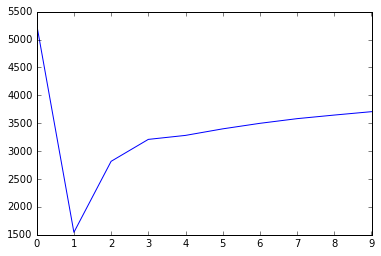

In [36]:
plt.plot(det)
plt.show()

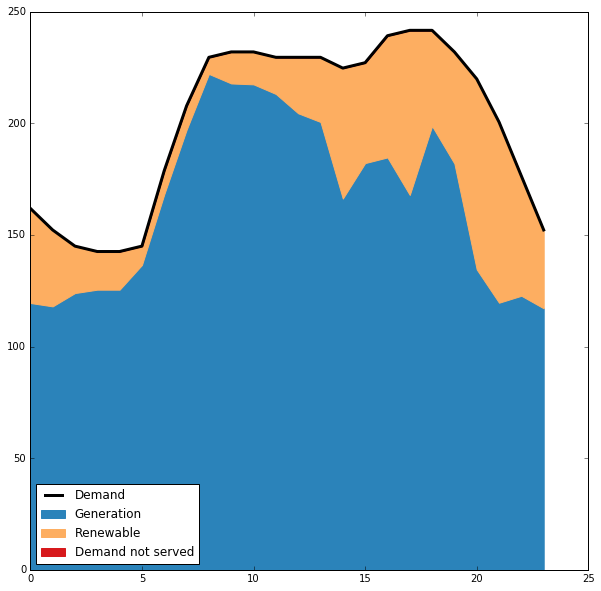

In [37]:
colors=['#d7191c','#fdae61','#abdda4','#2b83ba'] #['#ef8a62','#f7f7f7','#67a9cf','#008837']
plt.figure(figsize=(10,10))
plt.fill_between(range(n_h),np.zeros(n_h),np.squeeze(np.asarray(sum(p.value))),color=colors[3])
plt.fill_between(range(n_h),np.squeeze(np.asarray(sum(p.value))),
                 np.squeeze(np.asarray(sum(p.value)+sum(s.value))),
                 color=colors[1])

plt.fill_between(range(n_h),np.squeeze(np.asarray(sum(b))),
                 np.squeeze(np.asarray(sum(load.value))),
                 color=colors[0])
plt.plot(range(n_h),np.squeeze(np.asarray(sum(b))),color='k',linewidth=3.0)
# plt.fill_between(range(n_h),np.zeros(n_h),-np.squeeze(np.asarray(-sum(s.value)+sum(r))),color=colors[2])
plt.legend(['Demand','Generation','Renewable','Demand not served','Curtailed Renewable '],loc='best')
plt.show()

[('Nuclear', 1175.6449291411643), ('IGCC', 602.463650124271), ('CCGT', 1011.4549431224709), ('OCGT', 133.71810526259921), ('Coal', 1043.435207260964)]


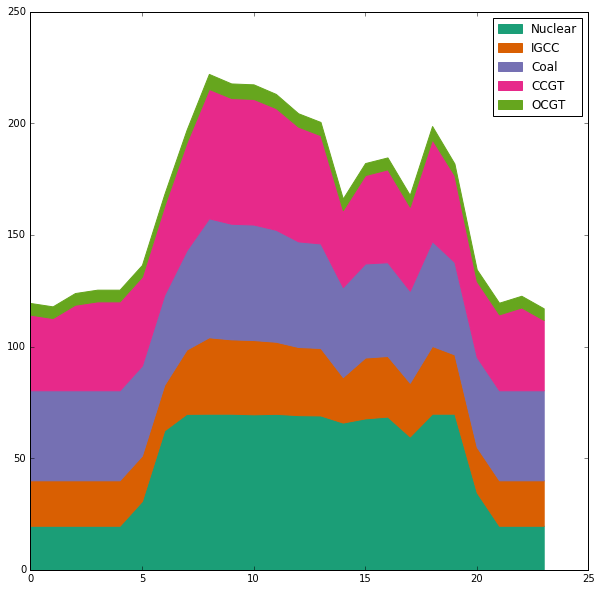

In [38]:
total_p_gen=np.sum(p.value,1)
total_share=[]
n_gen_per_tech=[]
for name in name_techno:
    total_share.append((name,np.sum([ total_p_gen[i] for i in range(num_p) if gen_tech[i]==name  ])))
print total_share
# sorted_name_techno=[x[0] for x in sorted(total_share,key =lambda x: x[1],reverse=True)]
sorted_name_techno=['Nuclear','IGCC','Coal','CCGT','OCGT']
colors=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']#list((['#f0f9e8','#bae4bc','#7bccc4','#43a2ca','#0868ac']))
share_per_hour=np.zeros([len(name_techno)+1,n_h])
plt.figure(figsize=(10,10))
for idx,name in enumerate(sorted_name_techno):
    share_per_hour[idx+1]=np.sum([ np.squeeze(np.asarray(p.value[i])) for i in range(num_p) if gen_tech[i]==name ],0)
share_per_hour=np.cumsum(share_per_hour,0)
for idx,name in enumerate(sorted_name_techno):
    plt.fill_between(range(n_h),share_per_hour[idx],share_per_hour[idx+1],color=colors[idx])
plt.legend(sorted_name_techno,loc='best')
plt.show()

for idx, name in enumerate(sorted_name_techno):
    n_gen_per_tech.append(sum([1 for i in range(num_p) if gen_tech[i]==name]))

In [50]:
np.max(J*w.value)

15.0

Nuclear
IGCC
Coal
CCGT
OCGT


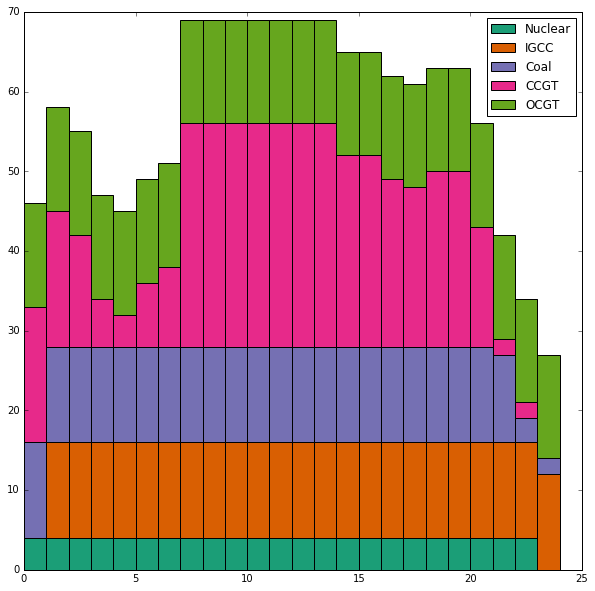

In [43]:
o_test=on_off_array[9]
sorted_name_techno=['Nuclear','IGCC','Coal','CCGT','OCGT']
N = n_h
ind = np.arange(N)  # the x locations for the groups
width = 1
aux=[]
aux.append(np.zeros(N).T)
cumsum_aux=np.zeros(N)
fig, ax = plt.subplots(figsize=(10,10))
# rects = ax.bar(ind, strategy1_optMean, width, color=color[0])
colors=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
for idx,name in enumerate(sorted_name_techno):
    print name
    aux.append(np.array([np.sum(np.ceil(o_test[j,i]) for j in range (num_p) if gen_tech[j]==name) for i in range(n_h)]))
    cumsum_aux=np.cumsum(aux,0)
#     print aux[-1]
    rects = ax.bar(ind, aux[idx+1], width, color=colors[idx],bottom=cumsum_aux[idx])
plt.legend(sorted_name_techno,loc='best')  
plt.show()


In [52]:
import pickle


In [53]:
# pickle.dump( on_off_array, open( "pickle/Stoch_Hybrid_ieee300_gurobi_test_3pwl.p", "wb" ) )

In [67]:
on_off_array[-1]

matrix([[ 1.,  1.,  1., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  1.],
        [ 1.,  1.,  0., ...,  0.,  1.,  0.],
        ..., 
        [ 1.,  1.,  1., ...,  0.,  1.,  0.],
        [ 1.,  1.,  1., ...,  0.,  1.,  0.],
        [ 1.,  1.,  1., ...,  0.,  1.,  0.]])